# <span style="color:blue"> <U/> Similar Products Recommendation for Big basket Dataset</span>

###  Dataset Description

- Bigbasket is the largest online grocery supermarket in India. Was launched somewhere around in 2011 since then they've been expanding their business. Though some new competitors have been able to set their foot in the nation such as Blinkit etc. but BigBasket has still not loose anything - thanks to ever expanding popular base and their shift to online buying.


- The link for the dataset is 
<a href="url" target="_blank">https://www.kaggle.com/datasets/surajjha101/bigbasket-entire-product-list-28k-datapoints</a>



- There are 27555 rows in dataset , 
  The dataset contains 10 attributes (columns) with simple meaning and which are described as follows:
  
  
 | Column | Description |
 | :---  | :---  |
    | index |Simply the Index
	| product |Title of the product (as they're listed)-**23541 unique values**
	| category | Category into which product has been classified- **11 unique categories**
	| sub_category | Subcategory into which product has been kept-**90 unique sub_categories**
    | brand |Brand of the product- **2314 unique brands**
	| sale_price |Price at which product is being sold on the site
	| market_price |Market price of the product
	| type |Type into which product falls- **426 unique types**
	| rating |Rating the product has got from its consumers
	| description|Description of the product (in detail)



## Business Objective (Problem) and Constraints:

- To recommend products as much as similar (relevant) to the product searched in Big basket search query
- Incorrect recommendations could impact customer experience
- Low latency requirement

## ML problem formulation:

- It is a Item- Item based Collabarative Filtered recommender system problem
- Item based Collabarative Filtering Recommender system uses similarity between items as a measure to recommend similar items to the queried item

## Performance Metrics:

- Cosine similarity will be used to find similar items for the given query item using the item (product) details  while modelling
- Cosine similarity is a metric, helpful in determining, how similar the data objects(two products) are, In cosine similarity, data objects in a dataset are treated as a vector. The formula to find the cosine similarity between two vectors is 
       
    Cos(x, y) = x . y / ||x|| * ||y||
    
    where,
           x . y = product (dot) of the vectors ‘x’ and ‘y’.
          ||x|| and ||y|| = length of the two vectors ‘x’ and ‘y’.
          ||x|| * ||y|| = cross product of the two vectors ‘x’ and ‘y’

Source: https://www.geeksforgeeks.org/cosine-similarity/

- In Real time, metrics described above don’t show us how real customers react to the produced recommendations in terms of the company’s business strategy. The only way to measure it is A/B testing. A/B testing costs more resources and time, but it allows us to measure the model performance,One of techniques used in A/B testing is *`Click Through Rate(CTR)`*



### Overview Of Data

In [1]:
#import all the necessary packages.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from scipy.sparse import hstack
from sklearn.cluster import KMeans
from tqdm import tqdm
import pickle
import re

In [2]:
# we have give a csvfile which consists of all information about
# the products
# loading the data using pandas' read_csv file.
data=pd.read_csv(r'BigBasket Products.csv')
data.head(3)

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."


In [3]:
print ('Number of data points : ', data.shape[0],'\nNumber of features/variables:', data.shape[1])

Number of data points :  27555 
Number of features/variables: 10


In [4]:
# each product/item has 10 features in the raw dataset.
data.columns # prints column-names or feature-names.

Index(['index', 'product', 'category', 'sub_category', 'brand', 'sale_price',
       'market_price', 'type', 'rating', 'description'],
      dtype='object')

In [5]:
# info about the data features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27555 entries, 0 to 27554
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         27555 non-null  int64  
 1   product       27554 non-null  object 
 2   category      27555 non-null  object 
 3   sub_category  27555 non-null  object 
 4   brand         27554 non-null  object 
 5   sale_price    27555 non-null  float64
 6   market_price  27555 non-null  float64
 7   type          27555 non-null  object 
 8   rating        18929 non-null  float64
 9   description   27440 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 2.1+ MB


In [6]:
# to know null values in each column/feature
data.isnull().sum()

index              0
product            1
category           0
sub_category       0
brand              1
sale_price         0
market_price       0
type               0
rating          8626
description      115
dtype: int64

Of these 10 features, we will be using only 6 features for our Model.

1.	category - Category into which product has been classified-11 unique categories
2.	sub_category - Subcategory into which product has been kept-90 unique sub_categories
3.	brand - Brand of the product-2314 unique brands
4.	type- Type into which product falls-426 unique types
5.  sale_price - Price at which product is being sold on the site
6. description- Description of the product (in detail)

  In addition to the above 6 features we will use newly built feature **`discount`** on product(i.e, market price-sell price/market price) , to rank the order of Recommended products


In [7]:
# creating new column discount_%
data['discount_%']=(data['market_price']-data['sale_price'])/data['market_price']

In [8]:
# selecting the required columns from dataframe for our analysis and model building
data=data[['product','category','sub_category','brand','type','description','sale_price','market_price','discount_%']]
data.head(2)

,product,category,sub_category,brand,type,description,sale_price,market_price,discount_%
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,Hair Oil & Serum,This Product contains Garlic Oil that is known...,220.0,220.0,0.0
1,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,Water & Fridge Bottles,"Each product is microwave safe (without lid), ...",180.0,180.0,0.0


In [9]:
# will remove rows with missing value in columns product,brand,description
data=data[~data['product'].isna()] # removing row with missing product value
data=data[~data['brand'].isna()]
data=data[~data['description'].isna()]
data.shape

(27439, 9)

- After removing missing **'product','brand','description'** datapoints reduced from 27555 to 27439 (99.57 % data retained)

In [10]:
# to find the row with value null
data.isnull().any()

product         False
category        False
sub_category    False
brand           False
type            False
description     False
sale_price      False
market_price    False
discount_%      False
dtype: bool

In [11]:
# splitting data into train and test 
from sklearn.model_selection import train_test_split

data_train,data_test=train_test_split(data,test_size=0.2,random_state=33)

print('data_train shape',data_train.shape)
print('data_test shape',data_test.shape)

data_train shape (21951, 9)
data_test shape (5488, 9)


In [12]:
# resetting index
data_train=data_train.reset_index(drop=True)
data_test=data_test.reset_index(drop=True)

In [13]:
# saving to pickle files
import pickle
pickle.dump((data_train,data_test),open('test_and_train.pkl','wb'))

### EDA on train data

In [14]:
data_train.columns

Index(['product', 'category', 'sub_category', 'brand', 'type', 'description',
       'sale_price', 'market_price', 'discount_%'],
      dtype='object')

In [15]:
# Univariate Analysis for feature 'product'
data_train['product'].describe()

count                            21951
unique                           19301
top       Turmeric Powder/Arisina Pudi
freq                                21
Name: product, dtype: object

- Out of 21951 train data, there are 19301 Unique values for `product` and top most occuring product is 'Turmeric Powder/Arisina Pudi' with 21 times 

In [16]:
# Univariate Analysis For feature category
data_train['category'].describe()

count                21951
unique                  11
top       Beauty & Hygiene
freq                  6306
Name: category, dtype: object

In [17]:
d1=data_train['category'].value_counts().reset_index()
d1.columns=['category','counts']
d1

,category,counts
0,Beauty & Hygiene,6306
1,Gourmet & World Food,3736
2,"Kitchen, Garden & Pets",2838
3,Snacks & Branded Foods,2245
4,Cleaning & Household,2128
5,"Foodgrains, Oil & Masala",2099
6,Beverages,701
7,"Bakery, Cakes & Dairy",685
8,Baby Care,495
9,Fruits & Vegetables,443


In [18]:
#https://www.w3schools.com/python/pandas/ref_df_cumsum.asp
#https://www.geeksforgeeks.org/how-to-rename-columns-in-pandas-dataframe/
cate=data_train['category'].value_counts(normalize=True).reset_index() # creating data frame with name cate for further processing
cate['cum_%']= cate['category'].cumsum()
cate.columns=['category','%','cum_%']
cate

,category,%,cum_%
0,Beauty & Hygiene,0.287276,0.287276
1,Gourmet & World Food,0.170197,0.457473
2,"Kitchen, Garden & Pets",0.129288,0.586761
3,Snacks & Branded Foods,0.102273,0.689035
4,Cleaning & Household,0.096943,0.785978
5,"Foodgrains, Oil & Masala",0.095622,0.881600
6,Beverages,0.031935,0.913535
7,"Bakery, Cakes & Dairy",0.031206,0.944741
8,Baby Care,0.022550,0.967291
9,Fruits & Vegetables,0.020181,0.987472


- `28.72%` of products fall in category of `Beauty & Hygenie`
- Gourmet & World Food occupies 17.01 % of total products
- followed by Kitchen, Garden & Pets which has a 12.92% share
- Snacks & Branded Foods has 10.2% share
- Rest of the categories have less than 1 percent share each in total products list

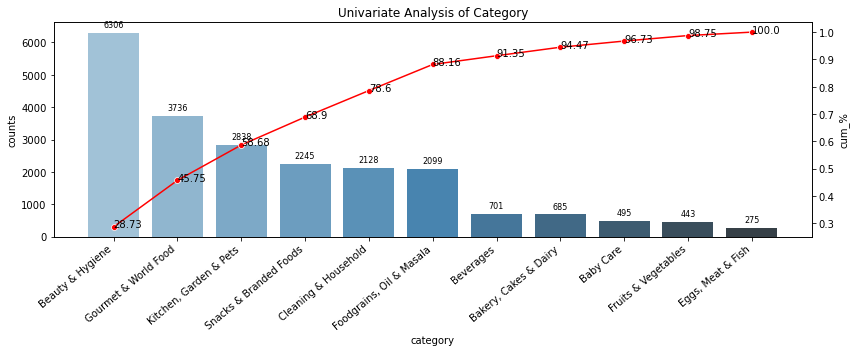

In [19]:
#https://stackoverflow.com/questions/37930693/how-can-i-make-a-barplot-and-a-lineplot-in-the-same-seaborn-plot-with-different
# we can combine line and bar graph in same plot using twinx() in seaborn
#https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
#https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
#https://www.easytweaks.com/matplotlib-seaborn-text-label-points/
plt.figure(figsize=(12,5))
ax=sns.barplot(x='category',y='counts',data=d1,palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40,ha="right")
for bar in ax.patches: # annotating bar graph 
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    
ax2=ax.twinx() # to include line graph with bar graph in same plot
ax2=sns.lineplot(x='category',y='cum_%',data=cate,marker="o",color='r')

for i,value in enumerate(cate['cum_%'].values): # to annotate line plot 
    ax2.text(cate['category'].values[i],cate['cum_%'].values[i]-0.0025,np.round(value*100,2))
    # putting text of cum_% value with respect to its x,y values
    #ax2,text(x-coordinate,ycordinate,value) # position of annotation
ax.set_title('Univariate Analysis of Category') # title the graph
plt.tight_layout()
plt.show()

In [20]:
# For feature 'sub_category'
data_train['sub_category'].describe()

count         21951
unique           90
top       Skin Care
freq           1814
Name: sub_category, dtype: object

In [21]:
data_train['sub_category'].value_counts()

Skin Care                   1814
Health & Medicine            927
Hair Care                    830
Fragrances & Deos            822
Storage & Accessories        821
                            ... 
Mutton & Lamb                 18
Water                         14
Flower Bouquets, Bunches       8
Pork & Other Meats             2
Marinades                      1
Name: sub_category, Length: 90, dtype: int64

In [22]:
data_train['sub_category'].value_counts(normalize=True)*100 # To get percentage

Skin Care                   8.263860
Health & Medicine           4.223042
Hair Care                   3.781149
Fragrances & Deos           3.744704
Storage & Accessories       3.740149
                              ...   
Mutton & Lamb               0.082001
Water                       0.063778
Flower Bouquets, Bunches    0.036445
Pork & Other Meats          0.009111
Marinades                   0.004556
Name: sub_category, Length: 90, dtype: float64

- The top four major sub_categories are as follows

   1.Skin Care- 8.26%<br/>
   2.Health & Medicine- 4.22%<br/>
   3.Hair Care-3.78%<br/> 
   4.Fragrances & Deos - 3.74%<br/> 

In [23]:
data_train['sub_category'].unique() # to get unique values of sub_category

array(['Organic Staples', 'Frozen Veggies & Snacks',
       'Rice & Rice Products', 'Cooking & Baking Needs',
       'Drinks & Beverages', 'Fragrances & Deos', 'All Purpose Cleaners',
       'Snacks, Dry Fruits, Nuts', 'Storage & Accessories',
       'Fresheners & Repellents', 'Diapers & Wipes', 'Masalas & Spices',
       'Tea', 'Snacks & Namkeen', 'Party & Festive Needs',
       'Cereals & Breakfast', 'Tinned & Processed Food',
       'Health & Medicine', 'Dry Fruits', 'Pooja Needs', 'Dairy',
       'Appliances & Electricals', 'Hair Care', 'Ready To Cook & Eat',
       'Pet Food & Accessories', 'Skin Care', 'Crockery & Cutlery',
       "Men's Grooming", 'Fish & Seafood', 'Pasta, Soup & Noodles',
       'Organic Fruits & Vegetables', 'Oils & Vinegar',
       'Spreads, Sauces, Ketchup', 'Steel Utensils', 'Bakeware',
       'Oral Care', 'Detergents & Dishwash', 'Bath & Hand Wash',
       'Cakes & Pastries', 'Sauces, Spreads & Dips', 'Fresh Vegetables',
       'Noodle, Pasta, Vermicelli',

In [24]:
#  top 10 sub_categories
subcategory_count=Counter(list(data_train['sub_category']))
subcategory_count.most_common(10)

[('Skin Care', 1814),
 ('Health & Medicine', 927),
 ('Hair Care', 830),
 ('Fragrances & Deos', 822),
 ('Storage & Accessories', 821),
 ('Bath & Hand Wash', 779),
 ('Masalas & Spices', 700),
 ('Crockery & Cutlery', 694),
 ('Snacks, Dry Fruits, Nuts', 677),
 ("Men's Grooming", 648)]

In [25]:
d1=data_train['sub_category'].value_counts().reset_index()[0:10] # selecting top 10 sub categories
d1.columns=['sub_category','counts'] # renaming colimns
d1

,sub_category,counts
0,Skin Care,1814
1,Health & Medicine,927
2,Hair Care,830
3,Fragrances & Deos,822
4,Storage & Accessories,821
5,Bath & Hand Wash,779
6,Masalas & Spices,700
7,Crockery & Cutlery,694
8,"Snacks, Dry Fruits, Nuts",677
9,Men's Grooming,648


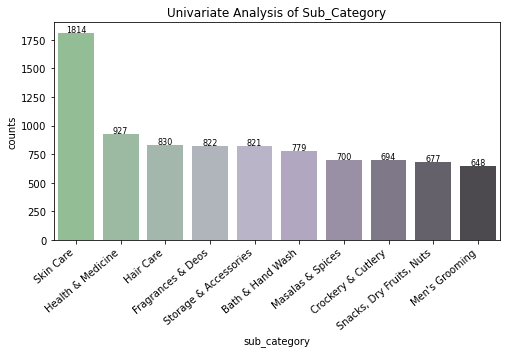

In [26]:
#ploting top 10 sub categories
#https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
#https://matplotlib.org/stable/gallery/userdemo/annotate_explain.html?highlight=annot
plt.figure(figsize=(8,4))
ax=sns.barplot(x='sub_category',y='counts',data=d1,palette="Accent_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40,ha="right")

# annotating values
for bar in ax.patches: # annotating bar graph 
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 3.5),
                   textcoords='offset points')
ax.set_title('Univariate Analysis of Sub_Category') # title the graph

plt.show()

In [27]:
# For Feature 'Brand'
data_train['brand'].describe()

count      21951
unique      2195
top       Fresho
freq         506
Name: brand, dtype: object

In [28]:
#  top 10 brand
brand_count=Counter(list(data_train['brand']))
brand_count.most_common(10)

[('Fresho', 506),
 ('bb Royal', 429),
 ('BB Home', 350),
 ('DP', 194),
 ('Fresho Signature', 133),
 ('bb Combo', 130),
 ('Amul', 120),
 ('GoodDiet', 118),
 ('Dabur', 112),
 ('INATUR ', 111)]

In [29]:
# percentage of top 10 brands
(data_train['brand'].value_counts(normalize=True)*100)[:10]

Fresho              2.305134
bb Royal            1.954353
BB Home             1.594460
DP                  0.883787
Fresho Signature    0.605895
bb Combo            0.592228
Amul                0.546672
GoodDiet            0.537561
Dabur               0.510227
INATUR              0.505672
Name: brand, dtype: float64

- There are 2195 unique brands 
- The brand which has highest number of products is Fresho - 506 counts - 2.3%

In [30]:
# For Feature 'type'
data_train['type'].describe()

count         21951
unique          423
top       Face Care
freq           1181
Name: type, dtype: object

In [31]:
#  top 10 type of products
type_count=Counter(list(data_train['type']))
type_count.most_common(10)

[('Face Care', 1181),
 ('Ayurveda', 444),
 ("Men's Deodorants", 407),
 ('Shampoo & Conditioner', 364),
 ('Containers Sets', 343),
 ('Glassware', 327),
 ('Bathing Bars & Soaps', 308),
 ('Blended Masalas', 306),
 ('Gourmet Tea & Tea Bags', 276),
 ('Body Care', 274)]

In [32]:
# percentage of top 10 types
(data_train['type'].value_counts(normalize=True)*100)[:10]

Face Care                 5.380165
Ayurveda                  2.022687
Men's Deodorants          1.854130
Shampoo & Conditioner     1.658239
Containers Sets           1.562571
Glassware                 1.489682
Bathing Bars & Soaps      1.403125
Blended Masalas           1.394014
Gourmet Tea & Tea Bags    1.257346
Body Care                 1.248235
Name: type, dtype: float64

- There are 423 unique types of product 
- Face care is the top type of product with 1181 counts- 5.38%

### sale_price

In [33]:
#  top sale_price
saleprice_count=Counter(list(data_train['sale_price']))
saleprice_count.most_common(10)

[(99.0, 325),
 (50.0, 260),
 (199.0, 248),
 (299.0, 240),
 (150.0, 237),
 (60.0, 232),
 (149.0, 203),
 (120.0, 197),
 (225.0, 197),
 (75.0, 194)]

In [34]:
data_train['sale_price'].value_counts().sort_index(ascending=False)

12500.00     1
10090.00     1
8184.44      1
7999.00      1
7299.00      1
            ..
7.50         2
6.00         7
5.00        16
3.00         1
2.45         1
Name: sale_price, Length: 2891, dtype: int64

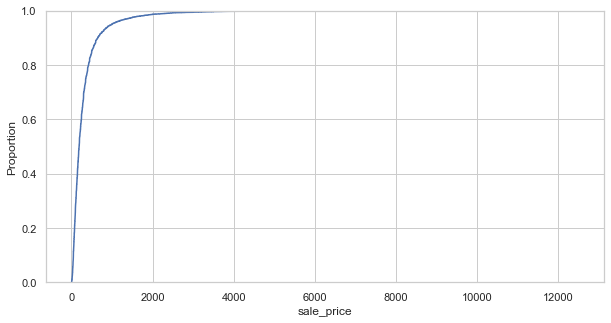

In [35]:
#CDF of sale_price
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('whitegrid')
sns.ecdfplot(data_train['sale_price'])

- 99% of products sale price is below 2000 in train data

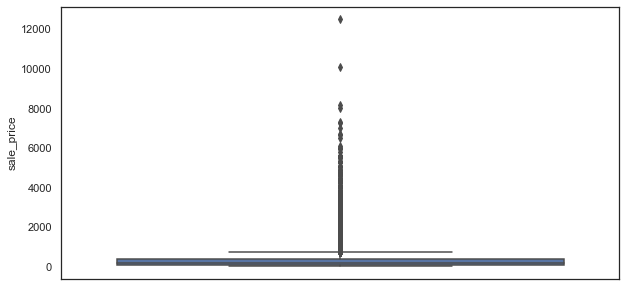

In [36]:
# Univariate analysis of sale_price
#Plotting of sale_price variable
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('white')
sns.boxplot(y=data_train['sale_price'])

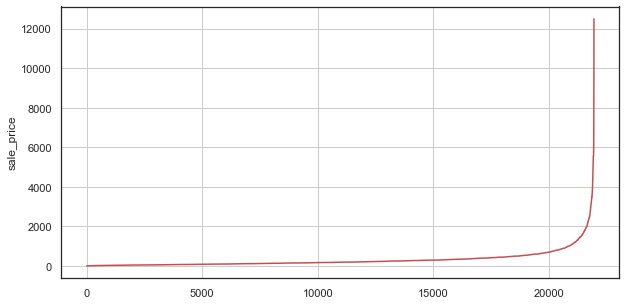

In [37]:
ypoints=np.array(data_train['sale_price'].sort_values())
plt.plot(ypoints,'r-')
plt.ylabel('sale_price')
plt.grid()
plt.show()

- From the above line plot there is a steep change at sale_price 2000(Inflection point)
- So will remove products whose sale_price is above 2000 

In [38]:
# data with sale price greater than 
data_saleprice=data_train[data_train['sale_price']>2000]
data_saleprice.shape

(303, 9)

In [39]:
data_train=data_train[data_train['sale_price']<=2000]
print("No. of data points after removing sale_price outliers:",data_train.shape[0])

No. of data points after removing sale_price outliers: 21648


- Datapoints reduced to 21648 (99.98% of original data)in train data from 21951 after removing products with sale price greater than 2000

### Description feature

In [40]:
data_train['description'].value_counts()

A brand inspired by the Greek goddess of victory, it personifies strength, speed and energy and it launched its first perfume in 1929. Since then, a wide assortment of fragrance collections has hit the marketplace with refreshing, and eye-catching proposals that capture the essence and lifestyle of today´s man and woman.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [41]:
data_train['description'].isna().sum() # to check for any missing values

0

In [42]:
data_train[data_train['description']==u' '].any().sum() # to check for just space in description

0

## Data Preprocessing

In [43]:
# we use the list of stop words that are downloaded from nltk lib.
import nltk # to download only once
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Muheebpashasnr\AppData\Roaming\nltk_data...


list of stop words: {'are', 'ma', "shan't", 'it', 'will', 'does', 'most', 'her', 'is', 'itself', 'not', 'if', 'themselves', 'himself', 've', 'once', 'from', 's', 'whom', 'won', 'so', 'hasn', 'mightn', 'yourself', 'can', "doesn't", 'have', 'down', 'no', "you'd", 'haven', 'd', 'shouldn', 'an', "you're", 'into', 'those', 'than', 'his', 'were', 'all', 'the', 'there', 'which', 'until', 'against', 'over', 'through', 'now', 'theirs', 'who', 'more', 'nor', 'yours', 'you', 'off', "won't", 'don', 'your', 'what', 'some', 'a', 'and', 'any', 'couldn', 'i', 'at', 'this', 'doing', 'weren', 'during', 'own', "shouldn't", 'where', "mustn't", 'again', 'only', 'they', 'out', "haven't", 'their', 'm', 'she', 'having', 'herself', 'to', 'am', 'needn', 'our', "that'll", 'such', 'ourselves', 'with', 'should', 'hadn', 'each', 'above', 'too', 'when', 'before', 'in', 'do', 're', 'y', 'for', 'then', 'between', 'wouldn', 'him', 'its', 'hers', 'by', 'up', "you'll", 'that', "it's", 'both', 'didn', 'doesn', 'or', 'furt

[nltk_data]   Package stopwords is already up-to-date!


### Categorical  features `'Category','sub_category','brand','type'`

In [44]:
# preprocressing category feature
## https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
def preprocess_categorical(data,column_name):
    """ fuction to preprocess categorical data column"""
    
    data[column_name]=data[column_name].str.replace('&','_') # replacing & with _
    data[column_name]=data[column_name].str.replace(',','_') # replacing , with _
    data[column_name]=data[column_name].str.replace("'",'') #replacing ' with ''(no space)
    data[column_name]=data[column_name].str.replace(" ",'') # removing white spaces
    data[column_name]=data[column_name].str.lower() # to lower case
    data[column_name]=data[column_name].str.strip() # removing trailing and leading white space
    
    return data[column_name]

In [45]:
data_train['category']=preprocess_categorical(data_train,'category')

In [46]:
data_train['category'].unique() # to check

array(['foodgrains_oil_masala', 'snacks_brandedfoods',
       'gourmet_worldfood', 'beauty_hygiene', 'cleaning_household',
       'kitchen_garden_pets', 'babycare', 'beverages',
       'bakery_cakes_dairy', 'eggs_meat_fish', 'fruits_vegetables'],
      dtype=object)

In [47]:
data_train['sub_category']=preprocess_categorical(data_train,'sub_category')

In [48]:
data_train['sub_category'].unique()

array(['organicstaples', 'frozenveggies_snacks', 'rice_riceproducts',
       'cooking_bakingneeds', 'drinks_beverages', 'fragrances_deos',
       'allpurposecleaners', 'snacks_dryfruits_nuts',
       'storage_accessories', 'fresheners_repellents', 'diapers_wipes',
       'masalas_spices', 'tea', 'snacks_namkeen', 'party_festiveneeds',
       'cereals_breakfast', 'tinned_processedfood', 'dryfruits',
       'health_medicine', 'poojaneeds', 'dairy', 'appliances_electricals',
       'haircare', 'readytocook_eat', 'petfood_accessories', 'skincare',
       'crockery_cutlery', 'mensgrooming', 'fish_seafood',
       'pasta_soup_noodles', 'organicfruits_vegetables',
       'spreads_sauces_ketchup', 'steelutensils', 'bakeware', 'oralcare',
       'detergents_dishwash', 'bath_handwash', 'cakes_pastries',
       'sauces_spreads_dips', 'freshvegetables',
       'noodle_pasta_vermicelli', 'bins_bathroomware',
       'mops_brushes_scrubs', 'chocolates_biscuits',
       'healthdrink_supplement', 'brea

In [49]:
data_train['brand']=preprocess_categorical(data_train,'brand')

In [50]:
data_train['brand'].nunique()

2158

In [51]:
data_train['type']=preprocess_categorical(data_train,'type')

In [52]:
data_train['type'].nunique()

422

### Description Feature

In [53]:
# preprocessing description
#https://stackoverflow.com/questions/30129936/python-regex-replace-sentence-with-starting-word
#https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
from tqdm import tqdm
import re
def preprocess_description(text):
    """ Function which does preprocesiing on prodcut title feature,
        removes stopwords, replaces special character with space, converts to lower case,
    """
    preprocessed_description=[]
    for description in tqdm(text):
        
        #Delete all the data which are present in the brackets
        description = re.sub(r'\([^()]*\)',' ',description)
        
        #removing urls
        description = re.sub(r'http\S+',' ',description)
        description = re.sub('[^A-Za-z]+', ' ', description) # remove all characters except a-z and A-Z and replace with white space
        # https://gist.github.com/sebleier/554280
        description = ' '.join(word for word in description.split() if word.lower() not in stop_words) # removing stop words
        description = ' '.join(word for word in description.split() if len(word)>2) # removing single letter and two letter words
        description = description.lower().strip()
        preprocessed_description.append(description)
        
    return preprocessed_description

In [54]:
preprocessed_description=preprocess_description(data_train['description'].values)

100%|█████████████████████████████████| 21648/21648 [00:02<00:00, 10061.89it/s]


In [55]:
data_train['description']=preprocessed_description

In [56]:
data_train

,product,category,sub_category,brand,type,description,sale_price,market_price,discount_%
0,Flour - Corn,foodgrains_oil_masala,organicstaples,organictattva,organicflours,per calories fat,57.00,60.0,0.050000
1,Veg. Burger Patty,snacks_brandedfoods,frozenveggies_snacks,yummiez,frozenvegsnacks,real good veg burger patty choice eating beefy...,125.00,125.0,0.000000
2,Dosa Rice/Akki,foodgrains_oil_masala,rice_riceproducts,supersaver,rawrice,rice dosa easy make premium dosa mix used make...,199.00,225.0,0.115556
3,Skimmed Milk Powder,gourmet_worldfood,cooking_bakingneeds,puramate,baking_cakedecorations,puramate skimmed milk powder makes wholesome m...,58.50,65.0,0.100000
4,Kiwi Drink,gourmet_worldfood,drinks_beverages,alafresh,gourmetjuices_drinks,ala fresh kiwi fruit drink refreshing fruit dr...,10.00,10.0,0.000000
...,...,...,...,...,...,...,...,...,...
21946,Tea Tree Anti Imperfection Daily Solution,beauty_hygiene,skincare,biotique,facecare,biotique tea tree anti imperfection daily solu...,420.00,560.0,0.250000
21947,Intimate Lightening Serum,beauty_hygiene,skincare,namyaa,intimatewash_care,adore flawless skin wish perfect skin tone fee...,750.00,750.0,0.000000
21948,Paw'sitively Smooth Paw Butter For Dogs,kitchen_garden_pets,petfood_accessories,captainzack,petcleaning_grooming,paw sitively smooth protects lovely pooch paws...,350.00,350.0,0.000000
21949,Colorsilk Hair Colour With Keratin,beauty_hygiene,haircare,revlon,haircolor,colorsilk ammonia permanent hair colour infuse...,413.25,435.0,0.050000


In [57]:
print('Printing some random description values')
print('-'*50)
print('[9]',data_train['description'][9])
print('-'*50)
print('[288]',data_train['description'][288])
print('-'*50)
print('[457]',data_train['description'][457])
print('-'*50)

Printing some random description values
--------------------------------------------------
[9] lunch box elegant trendy product asian plastics outer body lid made food grade material inner bowl lid made top quality stainless steel keeping food fresh longer period time lunch box also comes handle easy carrying
--------------------------------------------------
[288] britannia treat wafers strawberry discovering journey taste filled layers crispy wafers strawberry flavour gives taste buds delectable taste crunchiness wafers adds newness believing delivering fresh healthy products britannia india manufactures india favourite brands like tiger nutrichoice bourbon good day milk bikis little hearts
--------------------------------------------------
[457] aloe veda lavender face cleanser tea tree oil oil free non comedogenic formula containing active ingredients destroy bacteria face pores lead breakouts inflammation mild enough cause irritation inflammation skin oil free non comedogenic clog

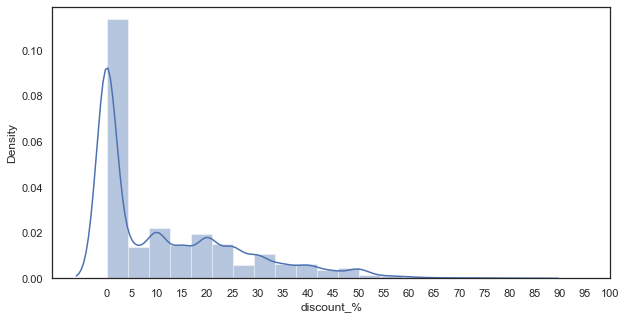

In [58]:
# Univariate analysis of discount_%
#Plotting of discount_% variable
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('white')
g=sns.distplot(data_train['discount_%']*100,bins=20)
g.set_xticks(np.arange(0,101,5))

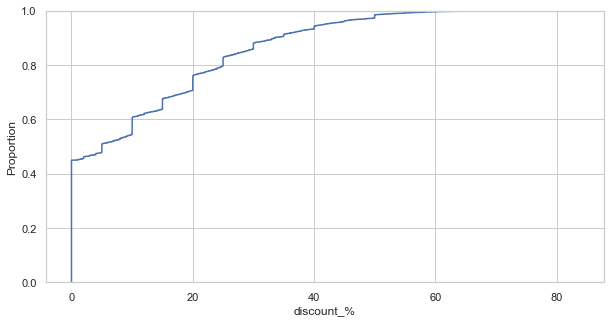

In [59]:
#CDF of discount_%
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('whitegrid')
sns.ecdfplot(data_train['discount_%']*100)

- Approx 46% of products have No discount(zero discount)
- Maximum discount for a product is 60% which is only for a small potion of total products(i.e,~1%)
- ~ 30% of products have discount from 1 to 20%
- ~ 15% of products have discount in range of 21-40% of market_price

### <u/> Clustering Analysis
- will compute sentiment scores for description text which we will use in clustering analysis

In [60]:
# computing sentiment score for description feature
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Muheebpashasnr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [61]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
sia=SentimentIntensityAnalyzer()

# saving sentiment scores in list 
negative=[]
neu=[]
pos=[]
compound=[]

for description in tqdm(data_train['description']):
    i=sia.polarity_scores(description)['neg']
    j=sia.polarity_scores(description)['neu']
    k=sia.polarity_scores(description)['pos']
    l=sia.polarity_scores(description)['compound']
    negative.append(i)
    neu.append(j)
    pos.append(k)
    compound.append(l)

100%|███████████████████████████████████| 21648/21648 [01:18<00:00, 276.76it/s]


In [62]:
# adding sentiment intensity analyser scores to dataframe as columns
data_train['negative']=negative
data_train['neutral']=neu
data_train['positive']=pos
data_train['compound']=compound

In [63]:
data_train['sale_price'].describe()

count    21648.000000
mean       279.441729
std        295.756692
min          2.450000
25%         94.500000
50%        189.000000
75%        349.000000
max       2000.000000
Name: sale_price, dtype: float64

In [64]:
sale_price_min=data_train['sale_price'].min()
sale_price_min

2.45

In [65]:
sale_price_max=data_train['sale_price'].max()
sale_price_max

2000.0

In [66]:
# scaling the sale price using min max scaler and aading it as new column to dataframe
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_train['sale_price_scaled']=scaler.fit_transform(data_train['sale_price'].values.reshape(-1,1))

In [67]:
data_train.head()

,product,category,sub_category,brand,type,description,sale_price,market_price,discount_%,negative,neutral,positive,compound,sale_price_scaled
0,Flour - Corn,foodgrains_oil_masala,organicstaples,organictattva,organicflours,per calories fat,57.0,60.0,0.050000,0.0,1.000,0.000,0.0000,0.027308
1,Veg. Burger Patty,snacks_brandedfoods,frozenveggies_snacks,yummiez,frozenvegsnacks,real good veg burger patty choice eating beefy...,125.0,125.0,0.000000,0.0,0.611,0.389,0.9484,0.061350
2,Dosa Rice/Akki,foodgrains_oil_masala,rice_riceproducts,supersaver,rawrice,rice dosa easy make premium dosa mix used make...,199.0,225.0,0.115556,0.0,0.811,0.189,0.8126,0.098396
3,Skimmed Milk Powder,gourmet_worldfood,cooking_bakingneeds,puramate,baking_cakedecorations,puramate skimmed milk powder makes wholesome m...,58.5,65.0,0.100000,0.0,0.780,0.220,0.9723,0.028059
4,Kiwi Drink,gourmet_worldfood,drinks_beverages,alafresh,gourmetjuices_drinks,ala fresh kiwi fruit drink refreshing fruit dr...,10.0,10.0,0.000000,0.0,0.667,0.333,0.8402,0.003780


In [68]:
data_train[['sale_price_scaled','discount_%','negative','neutral','positive','compound']].describe()

,sale_price_scaled,discount_%,negative,neutral,positive,compound
count,21648.000000,21648.000000,21648.000000,21648.000000,21648.000000,21648.000000
mean,0.138666,0.118632,0.038257,0.670894,0.290848,0.776339
std,0.148060,0.147265,0.055506,0.131387,0.125547,0.311236
min,0.000000,0.000000,0.000000,0.108000,0.000000,-0.982000
25%,0.046081,0.000000,0.000000,0.584000,0.214000,0.735100
50%,0.093389,0.050000,0.000000,0.664000,0.294000,0.907300
75%,0.173488,0.200000,0.061000,0.748000,0.372000,0.964800
max,1.000000,0.836667,0.630000,1.000000,0.892000,0.999800


In [69]:
# concatenating sentiment scores of description,sale_price_scaled,discount_% for clustering analysis
# using only numerical features for getting means(cenytroids) of cluster for further assignment
#https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
X_train = np.hstack((data_train['sale_price_scaled'].values.reshape(-1,1),data_train['discount_%'].values.reshape(-1,1), \
           data_train['negative'].values.reshape(-1,1),data_train['neutral'].values.reshape(-1,1), \
           data_train['positive'].values.reshape(-1,1),data_train['compound'].values.reshape(-1,1)))

In [70]:
X_train.shape

(21648, 6)

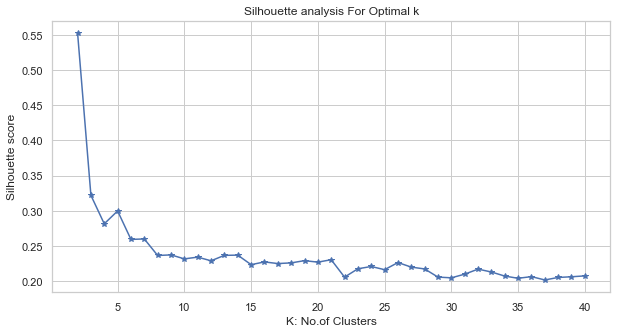

Wall time: 8min 20s


In [71]:
%%time
# performing clustering using Kmeans 
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score
#https://scikit-learn.org/stable/modules/clustering.html
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # to evaluate clustering performance
silhouette_scr=[]
K=range(2,41)
for k in K:
    kmeans=KMeans(n_clusters=k,n_init=12,max_iter=200) # setting KMeans cluster with 12 different centriod initializations & 200 iterations for a single run
    kmeans=kmeans.fit(X_train)
    labels=kmeans.labels_
    
    # silhouette score
    silhouette_scr.append(silhouette_score(X_train,labels))

plt.plot(K,silhouette_scr,'b*-')
plt.xlabel('K: No.of Clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

- For a good clustering silhouette score should be as close as to 1, but in our case the K with maximum silhouette score is 2, for optimum number of clusters will choose 5 as best_k by elbow method

In [72]:
# will group data into 5 clusters
best_k=5
kmeans=KMeans(n_clusters=best_k,n_init=12,max_iter=200) # setting KMeans cluster with 12 different centriod initializations & 200 iterations for a single run
kmeans=kmeans.fit(X_train)

In [73]:
labels=kmeans.labels_ # labels for each product given by clustering model
len(labels)

21648

In [76]:
# getting centroids
cluster_centers=kmeans.cluster_centers_
cluster_centers

array([[ 0.54857643,  0.11983299,  0.03506038,  0.64228334,  0.32264499,
         0.90715926],
       [ 0.10898021,  0.0897548 ,  0.0870934 ,  0.84675447,  0.06614374,
        -0.08649407],
       [ 0.1049003 ,  0.03575375,  0.03250612,  0.61690733,  0.35058553,
         0.92216618],
       [ 0.10346436,  0.09307554,  0.04148257,  0.77058688,  0.18793082,
         0.57071835],
       [ 0.11730835,  0.3167028 ,  0.03056984,  0.65071446,  0.31871776,
         0.90967596]])

In [77]:
#saving cluster centers to pkl file
pickle.dump(cluster_centers,open('cluster_centers.pkl','wb'))

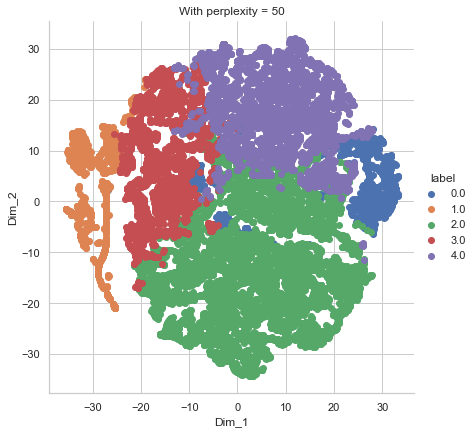

In [74]:
#visualising clusters using tsne
#https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
#https://plotly.com/python/t-sne-and-umap-projections/

# tsne for clustering with 5 clusters
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=500) 

projections=tsne.fit_transform(X_train)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((projections.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

- Cluster 0 has some overlap
- Rest clusters are separated to a good extent 

In [78]:
# inserting cluster_label as column 
data_train['cluster_label']=labels
data_train.head()

,product,category,sub_category,brand,type,description,sale_price,market_price,discount_%,negative,neutral,positive,compound,sale_price_scaled,cluster_label
0,Flour - Corn,foodgrains_oil_masala,organicstaples,organictattva,organicflours,per calories fat,57.0,60.0,0.050000,0.0,1.000,0.000,0.0000,0.027308,1
1,Veg. Burger Patty,snacks_brandedfoods,frozenveggies_snacks,yummiez,frozenvegsnacks,real good veg burger patty choice eating beefy...,125.0,125.0,0.000000,0.0,0.611,0.389,0.9484,0.061350,2
2,Dosa Rice/Akki,foodgrains_oil_masala,rice_riceproducts,supersaver,rawrice,rice dosa easy make premium dosa mix used make...,199.0,225.0,0.115556,0.0,0.811,0.189,0.8126,0.098396,3
3,Skimmed Milk Powder,gourmet_worldfood,cooking_bakingneeds,puramate,baking_cakedecorations,puramate skimmed milk powder makes wholesome m...,58.5,65.0,0.100000,0.0,0.780,0.220,0.9723,0.028059,2
4,Kiwi Drink,gourmet_worldfood,drinks_beverages,alafresh,gourmetjuices_drinks,ala fresh kiwi fruit drink refreshing fruit dr...,10.0,10.0,0.000000,0.0,0.667,0.333,0.8402,0.003780,2


In [79]:
#saving preprocessed train data to csv
data_train.to_csv('train_preprocessed_with_clusterlabels.csv',index=False)

In [80]:
# saving raw test data to csv
data_test.to_csv('test_raw.csv',index=False)

### <u/> References:

- https://www.geeksforgeeks.org/
- https://seaborn.pydata.org/generated/seaborn
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
- https://docs.python.org/3/library/re.html
- https://www.towardsdatascience.com/